In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import warnings
warnings.filterwarnings("ignore")

import time

## Описание

В данном ноутбуке представлен инференс предобученных моделей для опредления эмойций человека на изображении:
1. emotion_model - Модель, возвращающая категорию эмоции: страх, злось и так далее.
2. VA_model - Модель, возращающая непрерывные значения valence (знак) и arousal (интенсивности) эмоции.

Ноутбук с обучением модели: 

In [12]:
#@title Вспомогательные функции obtain_VA_classes и show_faces

class_indices = {0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise',
 8: 'uncertain'}


def show_faces(VA_model=None,
               emotion_model=None,
               img_gen=None):

  img_gen.shuffle = False
  data = next(img_gen)
  VA_pred = VA_model.predict(data)
  if emotion_model is not None:
    emotions = emotion_model.predict(data)

  plt.figure(figsize=(12,12))

  for i in range(16):
    plt.subplot(4,4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(data[i]/255)
    if emotion_model is None:
      plt.title(f'valence = {VA_pred[0][i][0]:.2f}\narousal = {VA_pred[1][i][0]:.2f}')
    else:
      plt.title(f'emotion = {class_indices[np.argmax(emotions[i])]}\nval = {VA_pred[0][i][0]:.2f}, ar = {VA_pred[1][i][0]:.2f}')

  plt.subplots_adjust(wspace=0.4)


def show_one_face(path=None):
  'Показывает случайное изображение из тестовой выборки'
  if path is None: path = f'/content/test_kaggle/{np.random.randint(1,5000)}.jpg'
  img = plt.imread(path)
  plt.figure(figsize=(8,8))
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img);

def predict_all(emotion_model=None,
                img_gen=None):
  'Предсказывает все значения из генератора. Возвращает датафрейм с результатами, сохраняет csv.'
  st = time.time()
  emotions = emotion_model.predict(img_gen)
  end = time.time()
  print(f'время инфенса: {end - st} секунд')
  df = pd.DataFrame({'image_path':img_gen.filenames, 
                     'emotion':np.argmax(emotions, axis=1),})
  df['image_path'] = df.image_path.str[12:]
  df['emotion'] = df.emotion.apply(lambda x: class_indices[x])
  df.to_csv('/content/predicted_submition.csv', index=False)
  df
  return df

In [ ]:
!gdown --id 1bGHeWeWYXj5biL9s-qTc9gyv91WNAbWE
!unzip '/content/test_kaggle.zip'

!gdown --id 1P9Tad6vLX5IeyZ1yRlfA3IFvvm7bd5EW
!unzip '/content/EmotionRecognition_model_3.zip'
emotion_model = tf.keras.models.load_model('/content/3')

!gdown --id 1TGBM0JhENyWrqb-oWzCgCazztcJkUPaN
!unzip '/content/VA_model.zip'
VA_model = tf.keras.models.load_model('/content/VA_model/1')


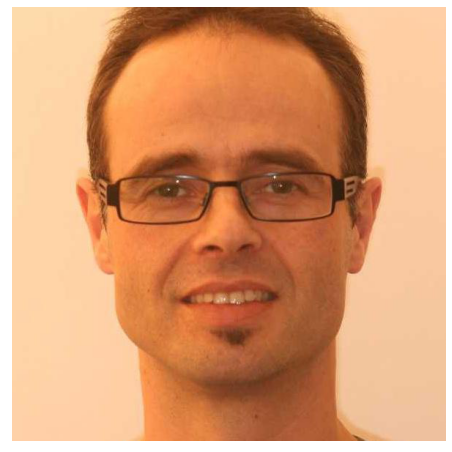

In [4]:
show_one_face()

In [5]:
# Подгружаю в генератор тестовый датасэт из задания
BATCH_SIZE = 32
IMG_SHAPE = 150

test_image_gen = tf.keras.preprocessing.image.ImageDataGenerator()
test_image_data_gen = test_image_gen.flow_from_directory(
    directory='/content',
    classes=['test_kaggle'],
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    seed=42
    )


Found 5000 images belonging to 1 classes.


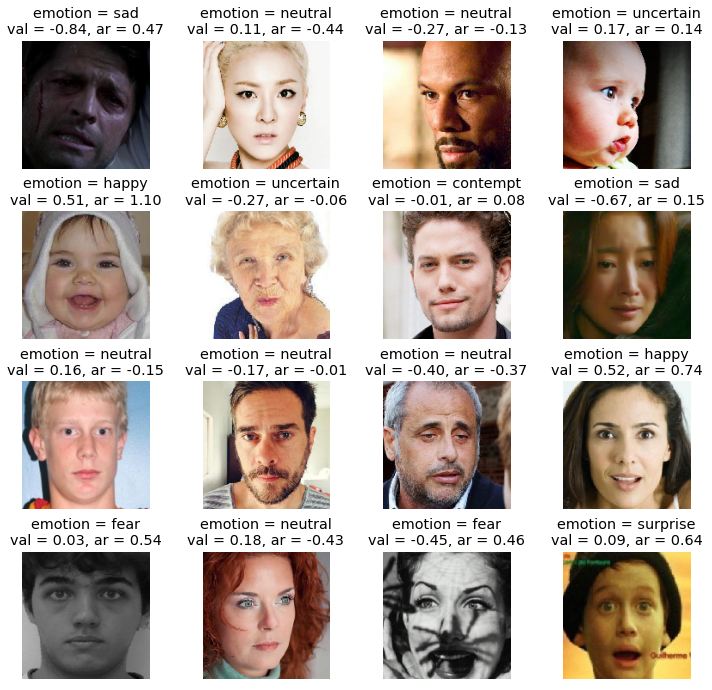

In [6]:
# Выполняю предик и сразу вывожу несколько примеров
show_faces(VA_model=VA_model, 
           emotion_model=emotion_model, 
           img_gen=test_image_data_gen)


In [13]:
predictions_df = predict_all(emotion_model, test_image_data_gen)
predictions_df

время инфенса: 35.13503432273865 секунд


,image_path,emotion
0,0.jpg,sad
1,1.jpg,neutral
2,10.jpg,neutral
3,100.jpg,uncertain
4,1000.jpg,happy
...,...,...
4995,995.jpg,happy
4996,996.jpg,happy
4997,997.jpg,anger
4998,998.jpg,neutral


## Результат
По условиям задачи необходимо, чтобы результат на private leaderboard был > 0.4, а время инференса < 330мс (0.33 секунды).
- Private Score: 0.42280
- Время инференса в среднем 7мс либо 35 секунды на 5000 изображений.


Downloading...
From: https://drive.google.com/uc?id=1nj2T5ZW2oYbDzefgAZ_QM1SuAkfExtU2
To: /content/diploma_submission.png
100% 134k/134k [00:00<00:00, 41.0MB/s]


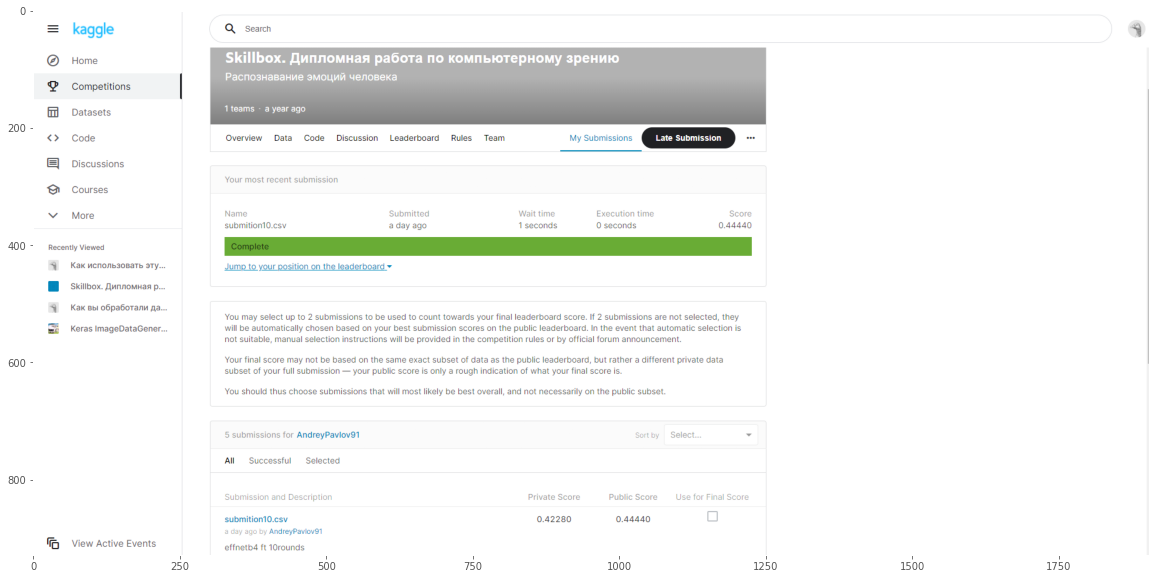

In [14]:
#скриншот с kaggle
!gdown --id 1nj2T5ZW2oYbDzefgAZ_QM1SuAkfExtU2
img = plt.imread('/content/diploma_submission.png')
plt.figure(figsize=(20,20))
plt.grid(False)
plt.imshow(img);

## Выводы
Люди способны выражать широкий спектр эмоций. Каждый человек выражает эмоции несколько по-разному. И тем не менее робот уже способен с высокой точностью определять, притом делать это в различных формах - как выбор из дискретного набора, так и значение на непрерывных спектрах в случае знака и интенсивности.

Данная технология может помогать отслеживать user experience от просмотра сериала или вождения автомобиля, комфорт работы в больших компаниях и даже состояние пациентов в больницах, предоставляя возможность реагировать еще до получения сигналов жизненных показателях.